## **UC San Diego Data Science Casptone Project [Winter 2025]**

#### **Team Members**
- Catherine Back
- Yuancheng (Kaleo) Cao
- Aj Falak
- Kavya Sriram

### **Introduction**

### **Data Cleaning**

#### Get and Load Dataset

In [106]:
# !pip install aif360
# !pip install 'aif360[all]'

In [107]:
# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset
# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover
# Explainers
from aif360.explainers import MetricTextExplainer

In [108]:
# Imports
import sys
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import scipy.stats as stats
from sklearn.metrics import confusion_matrix

In [109]:
import zipfile

zip_file_path = 'pretrial_release_data2023.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open('pretrial_release_data2023.csv') as csv_file:
        pretrial_df = pd.read_csv(csv_file)

pretrial_df

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
nan_percentages = pretrial_df.isna().mean() * 100
sorted_nan_percentages = nan_percentages.sort_values(ascending=False)
len(sorted_nan_percentages[sorted_nan_percentages > 1])

52

In [ ]:
sorted_nan_percentages
col_list = sorted_nan_percentages[sorted_nan_percentages > 1].index.tolist()
col_list

['First_Unsecured_App_Bond',
 'Partially_Secured_App_Bond_Perc',
 'First_Partially_Secured_App_Bond',
 'First_Unsecured_Surety_Bond',
 'First_Secured_App_Bond',
 'rearrest_date_firearm',
 'First_Secured_Surety_Bond',
 'First_Bail_Set_Credit',
 'Top_Arraign_Attempt_Indicator',
 'Days_Arraign_Remand_First_Released',
 'Days_Arraign_Bail_Set_to_First_Posted',
 'Bail_Made_Indicator',
 'Num_of_Stayed_WO',
 'First_Bench_Warrant_Date',
 'Non_Stayed_WO',
 'First_Insurance_Company_Bail_Bond',
 'Partially_Secured_Surety_Bond_Perc',
 'First_Partially_Secured_Surety_Bond',
 'Days_Arraign_Bail_Set_to_First_Release',
 'UCMSLiveDate',
 'rearrest_date',
 'First_Bail_Set_Cash',
 'Most_Severe_Sentence',
 'Top_Conviction_Law',
 'Top_Conviction_Article_Section',
 'Top_Charge_at_Conviction',
 'Top_Charge_Severity_at_Conviction',
 'Top_Charge_Weight_at_Conviction',
 'Order_of_Protection',
 'Days_Arraign_to_Dispo',
 'Disposition_Date',
 'arr_cycle_id',
 'rearrest',
 'prior_vfo_cnt',
 'prior_nonvfo_cnt',
 'pen

In [ ]:
pretrial_df = pretrial_df[pretrial_df['rearrest'].notna()]

In [ ]:
pretrial_df['rearrest'].value_counts()

rearrest
No Arrest             205084
Misdemeanor            19842
Non-violent felony     14813
Violent felony          4982
Name: count, dtype: int64

In [ ]:
pretrial_df.loc[:, 'reoffend'] = pretrial_df['rearrest'].apply(lambda x: 0 if x == 'No Arrest' else 1)

/var/folders/fy/20h6tjtj0lb6vgm0w4qt4m2c0000gn/T/ipykernel_15860/1792770735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrial_df.loc[:, 'reoffend'] = pretrial_df['rearrest'].apply(lambda x: 0 if x == 'No Arrest' else 1)


In [ ]:
pretrial_df = pretrial_df.copy()
pretrial_df.loc[:, 'First_Arraign_Date'] = pd.to_datetime(pretrial_df['First_Arraign_Date'])

In [ ]:
date_columns = [col for col in pretrial_df.columns if 'date' in col.lower()]
date_columns

['First_Arraign_Date',
 'First_Bench_Warrant_Date',
 'Disposition_Date',
 'UCMSLiveDate',
 'rearrest_date',
 'rearrest_date_firearm']

In [ ]:
pretrial_df.loc[:, 'First_Arraign_Date'] = pd.to_datetime(pretrial_df['First_Arraign_Date']).dt.date

### Checking Unique Values in Each Column for Typos/Unique Missing Values/Errors etc.

In [ ]:
#Converting Date Types
pretrial_df['First_Bench_Warrant_Date'] = pd.to_datetime(pretrial_df['First_Bench_Warrant_Date'], errors='coerce')
pretrial_df['Disposition_Date'] = pd.to_datetime(pretrial_df['Disposition_Date'], errors='coerce')
pretrial_df['UCMSLiveDate'] = pd.to_datetime(pretrial_df['UCMSLiveDate'], errors='coerce')
pretrial_df['rearrest_date_firearm'] = pd.to_datetime(pretrial_df['rearrest_date_firearm'], errors='coerce')
pretrial_df['rearrest_date'] = pd.to_datetime(pretrial_df['rearrest_date'], errors='coerce')


In [ ]:
# Renaming Columns for Consistency
pretrial_df['Offense Year'].sort_values().unique()
pretrial_df = pretrial_df.rename(columns={"Offense Year": "Offense_Year"})
pretrial_df['Offense_Year'] = pretrial_df['Offense_Year'].fillna(0).astype(int)

pretrial_df['Arrest Year'].sort_values().unique()
pretrial_df = pretrial_df.rename(columns={"Arrest Year": "Arrest_Year"})
pretrial_df['Arrest_Year'] = pretrial_df['Arrest_Year'].fillna(0).astype(int)

pretrial_df = pretrial_df.rename(columns={"Arraign Charge Category": "Arraign_Charge_Category"})
pretrial_df = pretrial_df.rename(columns={"Release Decision at Arraign": "Release_Decision_at_Arraign"})

In [ ]:
#Converting Types 
pretrial_df['App_Count_Arraign_to_Dispo_Released'] = pretrial_df['App_Count_Arraign_to_Dispo_Released'].astype(int)
pretrial_df['App_Count_Arraign_to_Dispo_Detained'] = pretrial_df['App_Count_Arraign_to_Dispo_Detained'].astype(int)
pretrial_df['App_Count_Arraign_to_Dispo_Total'] = pretrial_df['App_Count_Arraign_to_Dispo_Total'].astype(int)
pretrial_df['Def_Attended_Sched_Pretrials'] = pretrial_df['Def_Attended_Sched_Pretrials'].fillna(0).astype(int)
pretrial_df['Non_Stayed_WO'] = pretrial_df['Non_Stayed_WO'].fillna(0).astype(int)
pretrial_df['Num_of_Stayed_WO'] = pretrial_df['Num_of_Stayed_WO'].fillna(0).astype(int)
pretrial_df['Days_Arraign_Remand_First_Released'] = pretrial_df['Days_Arraign_Remand_First_Released'].fillna(0).astype(int)
pretrial_df['Days_Arraign_Bail_Set_to_First_Posted'] = pretrial_df['Days_Arraign_Bail_Set_to_First_Posted'].fillna(0).astype(int)
pretrial_df['Days_Arraign_Bail_Set_to_First_Release'] = pretrial_df['Days_Arraign_Bail_Set_to_First_Release'].fillna(0).astype(int)
pretrial_df['Days_Arraign_to_Dispo'] = pretrial_df['Days_Arraign_to_Dispo'].fillna(0).astype(int)
pretrial_df['prior_vfo_cnt'] = pretrial_df['prior_vfo_cnt'].astype(int)
pretrial_df['prior_nonvfo_cnt'] = pretrial_df['prior_nonvfo_cnt'].astype(int)
pretrial_df['prior_misd_cnt'] = pretrial_df['prior_misd_cnt'].astype(int)
pretrial_df['pend_vfo'] = pretrial_df['pend_vfo'].astype(int)
pretrial_df['pend_nonvfo'] = pretrial_df['pend_nonvfo'].astype(int)
pretrial_df['pend_misd'] = pretrial_df['pend_misd'].astype(int)
pretrial_df['supervision'] = pretrial_df['supervision'].astype(int)
pretrial_df['rearrest_firearm'] = pretrial_df['rearrest_firearm'].astype(int)

In [ ]:
#Replacing Unique NaN values with NaN
pretrial_df['Top_Severity_at_Arraign'] = pretrial_df['Top_Severity_at_Arraign'].replace(" ", np.nan)
pretrial_df['Disposition_Type'] = pretrial_df['Disposition_Type'].replace(" ", np.nan)
pretrial_df['Disposition_Detail'] = pretrial_df['Disposition_Detail'].replace(" ", np.nan)
pretrial_df['Dismissal_Reason'] = pretrial_df['Dismissal_Reason'].replace(" ", np.nan)
pretrial_df['Top_Conviction_Attempt_Indicator'] = pretrial_df['Top_Conviction_Attempt_Indicator'].replace(" ", np.nan)
pretrial_df['Top_Arrest_Attempt_Indicator'] = pretrial_df['Top_Arrest_Attempt_Indicator'].replace(" ", np.nan)


In [ ]:
#Drop columns `Court_Name` and `Court_ORI`
pretrial_df.drop(columns=['Court_Name', 'Court_ORI'], inplace=True)
print(pretrial_df.shape)

(244721, 111)


In [ ]:
#Drop Columns with 90% NaN Values
print(pretrial_df.shape)
pretrial_df.dropna(axis=1, thresh=0.9 * len(pretrial_df), inplace=True)
print(pretrial_df.shape)

(244721, 111)
(244721, 79)


### **Exploratory Data Analysis (EDA)**

#### Data Understanding

In [ ]:
summary_stats = pretrial_df.describe(include='all')
summary_stats

,Internal_Case_ID,Gender,Race,Ethnicity,Age_at_Crime,Age_at_Arrest,County_Name,District,Region,Court_Type,...,prior_nonvfo_cnt,prior_misd_cnt,pend_vfo,pend_nonvfo,pend_misd,supervision,rearrest,rearrest_firearm,arr_cycle_id,reoffend
count,244721,244721,244721,244721,244721.000000,244721.000000,244721,244721,244721,244721,...,244721.000000,244721.000000,244721.000000,244721.000000,244721.000000,244721.000000,244721,244721.000000,2.378710e+05,244721.000000
unique,244721,3,6,3,NaN,NaN,62,14,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN
top,0x7D5A7A079A4D37CF1E45EC4,Male,Black,Non Hispanic,NaN,NaN,Kings,District 2,NYC,Local,...,NaN,NaN,NaN,NaN,NaN,NaN,No Arrest,NaN,NaN,NaN
freq,1,195813,121197,158936,NaN,NaN,46127,46127,151943,207761,...,NaN,NaN,NaN,NaN,NaN,NaN,205084,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,35.097940,34.455498,NaN,NaN,NaN,NaN,...,0.474034,1.774993,0.077537,0.163251,0.217587,0.065581,NaN,0.004111,1.090061e+06,0.161968
std,NaN,NaN,NaN,NaN,12.467152,13.384345,NaN,NaN,NaN,NaN,...,0.967195,2.971150,0.267443,0.369595,0.412606,0.247548,NaN,0.063984,3.216342e+05,0.368422
min,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,1.611500e+04,0.000000
25%,NaN,NaN,NaN,NaN,26.000000,26.000000,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,9.226275e+05,0.000000
50%,NaN,NaN,NaN,NaN,33.000000,33.000000,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,1.125994e+06,0.000000
75%,NaN,NaN,NaN,NaN,43.000000,42.000000,NaN,NaN,NaN,NaN,...,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,1.328811e+06,0.000000


In [ ]:
missing_values = pretrial_df.isnull().sum().to_dict()
missing_values

{'Internal_Case_ID': 0,
 'Gender': 0,
 'Race': 0,
 'Ethnicity': 0,
 'Age_at_Crime': 0,
 'Age_at_Arrest': 0,
 'County_Name': 0,
 'District': 0,
 'Region': 0,
 'Court_Type': 0,
 'Judge_Name': 0,
 'Offense_Month': 1653,
 'Offense_Year': 0,
 'Arrest_Month': 6501,
 'Arrest_Year': 0,
 'Top_Arrest_Law': 5524,
 'Top_Arrest_Article_Section': 5524,
 'Top_Charge_at_Arrest': 5524,
 'Top_Charge_Severity_at_Arrest': 5524,
 'Top_Charge_Weight_at_Arrest': 5524,
 'Top_Charge_at_Arrest_Violent_Felony_Ind': 0,
 'Case_Type': 0,
 'First_Arraign_Date': 0,
 'Top_Arraign_Law': 1501,
 'Top_Arraign_Article_Section': 1501,
 'Top_Charge_at_Arraign': 1501,
 'Top_Severity_at_Arraign': 1934,
 'Top_Charge_Weight_at_Arraign': 1501,
 'Top_Charge_at_Arraign_Violent_Felony_Ind': 0,
 'Hate_Crime_Ind': 0,
 'Arraign_Charge_Category': 0,
 'Representation_Type': 2811,
 'App_Count_Arraign_to_Dispo_Released': 0,
 'App_Count_Arraign_to_Dispo_Detained': 0,
 'App_Count_Arraign_to_Dispo_Total': 0,
 'Def_Attended_Sched_Pretrials': 0

1. Several columns have few missing data, meaning they are mostly complete but still have some missing values that need attention. {`Offense_Month`: 1653, `Arrest_Month`: 6501, `Top_Arrest_Article_Section`: 5524, `Top_Charge_at_Arrest`: 5524, `Top_Charge_Severity_at_Arrest`: 5524, `Top_Charge_Weight_at_Arrest`: 5524, `Top_Arraign_Law`: 1501, `Top_Arraign_Article_Section`: 1501, `Top_Charge_at_Arraign`: 1501,  `Top_Charge_Weight_at_Arraign`: 1501, `Representation_Type`: 2811}
2. Several columns with significant missing values, which is concerning because these columns likely contain important information related to the case outcomes, bail conditions, or sentencing details. {`First_Bail_Set_Cash`: 200656, `First_Bench_Warrant_Date`: 218556, `Days_Arraign_Remand_First_Released`: 236156}
3. Some columns have very little data, with over 90% of the values missing. {`First_Unsecured_App_Bond`, `Partially_Secured_App_Bond_Perc`,`First_Partially_Secured_App_Bond`,`First_Unsecured_Surety_Bond`,`First_Secured_App_Bond`, `rearrest_date_firearm`, `First_Secured_Surety_Bond`, `First_Bail_Set_Credit`, `Top_Arraign_Attempt_Indicator`, `Days_Arraign_Remand_First_Released`, `Days_Arraign_Bail_Set_to_First_Posted`, `Bail_Made_Indicator`, `Num_of_Stayed_WO`}


| Column Name | Type | Values | Data Description |
|----------|------------|--------|------------------|
|pend_vfo|binary|0=No, 1=Yes|Indicator of one or more pending arrests for violent felonies|
|pend_nonvfo|binary|0=No, 1=Yes|Indicator of one or more pending arrests for non-violent felony offenses|
|Docket_Status|string|Disposed; Tolled/Open Warrant; Pending Disposition|Disposed (has a disposition date), Tolled/Open Warrant (pretrial only),Pending Disposition (not disposed, no open warrant or tolling). Tolling events can include things like stays in mental health facilities, military leave, and other events that stop the court's ability to process the case|
|rearrest|string|Violent felony, Non-violent Felony, Misdemeanor, No Arrest, NULL|Charge level of the first rearrest made for a new crime committed between arraignment and disposition on the current docket number; limited to an arrest for misdemeanor or felony offenses requiring fingerprints to be taken.|

#### Data Visualization

In [ ]:
demographics = ['Race', 'Ethnicity', 'Gender']

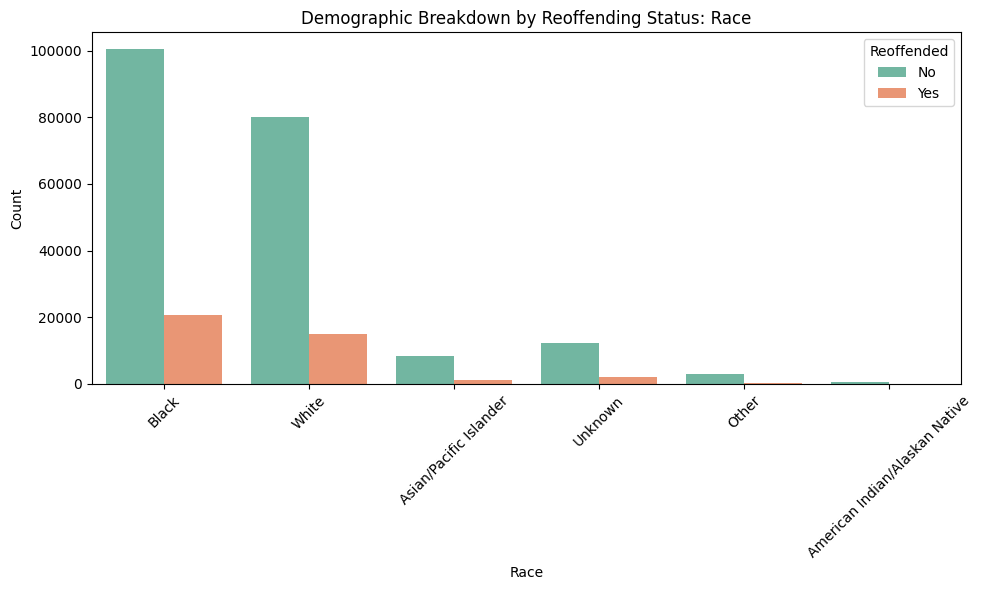

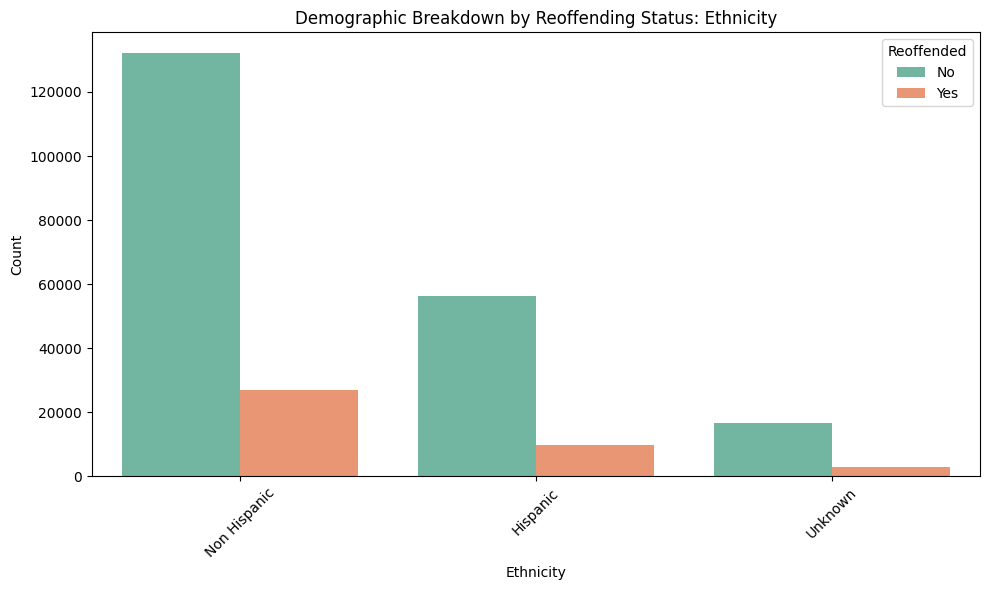

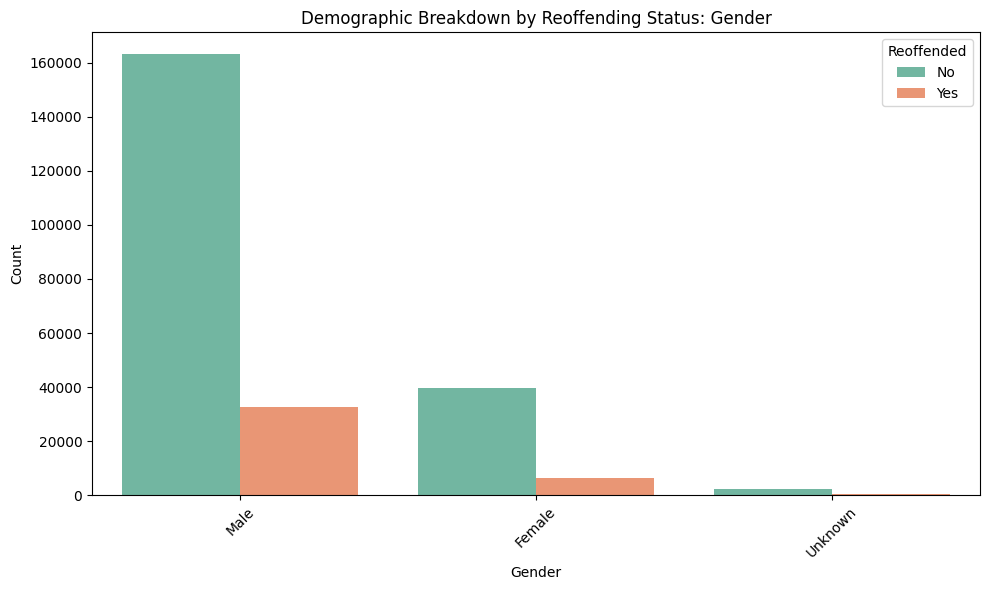

In [ ]:
for demo in demographics:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=demo, hue='reoffend', data=pretrial_df, palette='Set2')
    plt.title(f'Demographic Breakdown by Reoffending Status: {demo.capitalize()}')
    plt.xlabel(demo.capitalize())
    plt.ylabel('Count')
    plt.legend(title='Reoffended', labels=['No', 'Yes'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
pretrial_df['Days_Arraign_to_Dispo'].sort_values()

142473      0
138518      0
138512      0
138502      0
138496      0
         ... 
219952    416
3425      416
88408     418
200769    418
116396    420
Name: Days_Arraign_to_Dispo, Length: 244721, dtype: int64

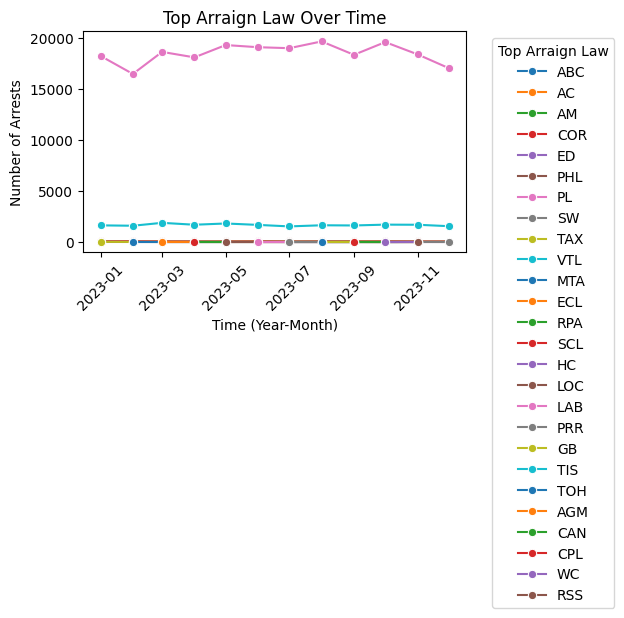

In [ ]:
pretrial_df['First_Arraign_Date'] = pd.to_datetime(pretrial_df['First_Arraign_Date'])
arrest_trend = pretrial_df.groupby(['First_Arraign_Date', 'Top_Arraign_Law']).size().reset_index(name='count')
sns.lineplot(data=arrest_trend, x='First_Arraign_Date', y='count', hue='Top_Arraign_Law', marker='o', palette='tab10')
plt.title('Top Arraign Law Over Time')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Number of Arrests')
plt.xticks(rotation=45)
plt.legend(title='Top Arraign Law', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
sum(pretrial_df['Age_at_Arrest'] != pretrial_df['Age_at_Crime'])

23555

Text(0, 0.5, 'Count')

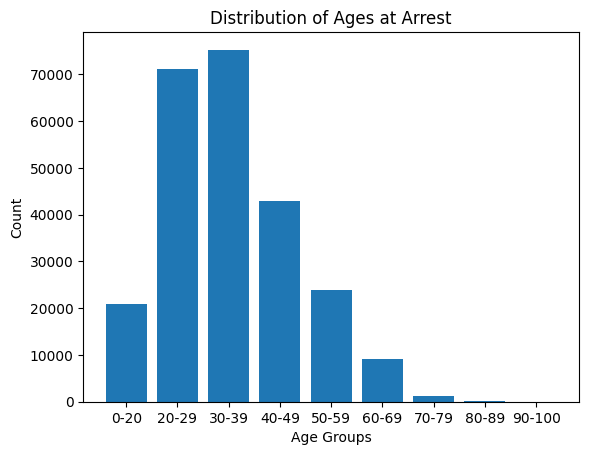

In [ ]:
# pretrial_df['Age_at_Arrest'].max() # max is 95
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
counts, bin_edges = np.histogram(pretrial_df['Age_at_Arrest'], bins=bins)
labels = ['0-20', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']

plt.bar(labels, counts)
plt.title('Distribution of Ages at Arrest')
plt.xlabel('Age Groups')
plt.ylabel('Count')


In [ ]:
for race in pretrial_df['Race'].unique():
    print(race)

Black
White
Asian/Pacific Islander
Unknown
Other
American Indian/Alaskan Native


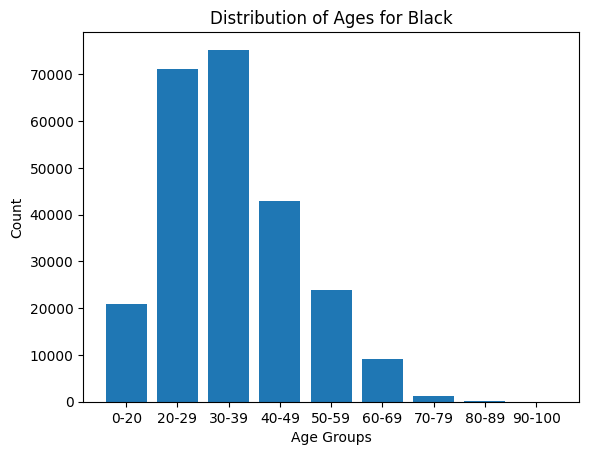

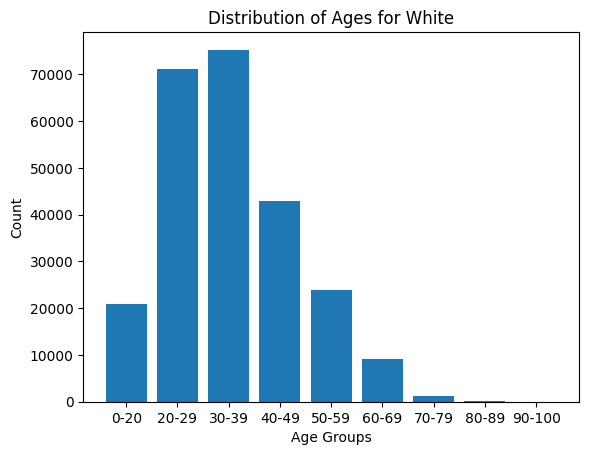

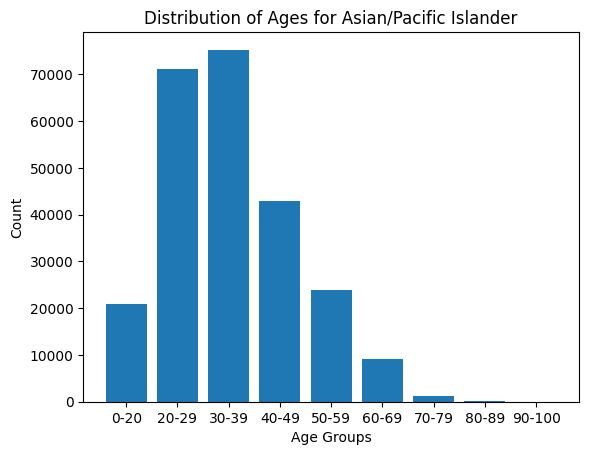

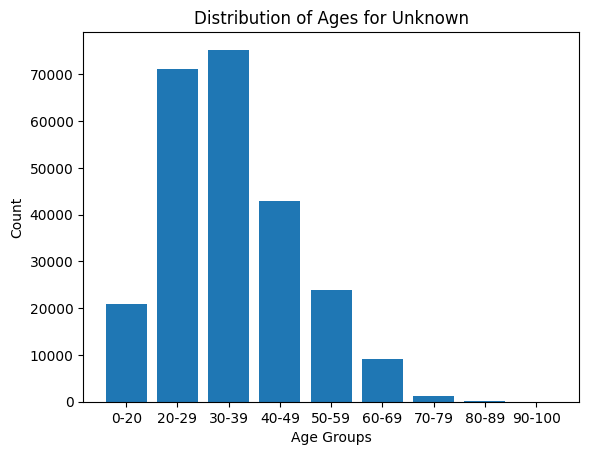

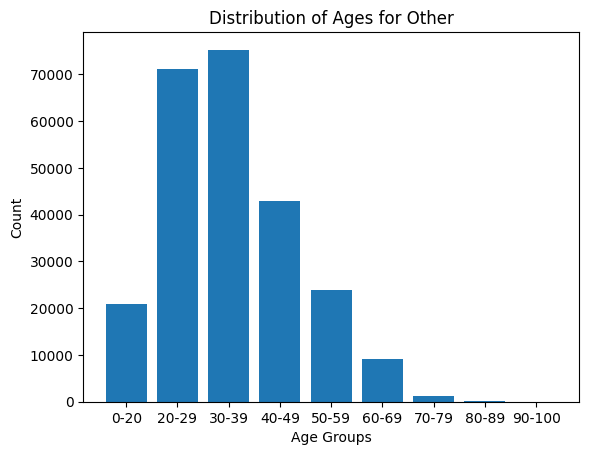

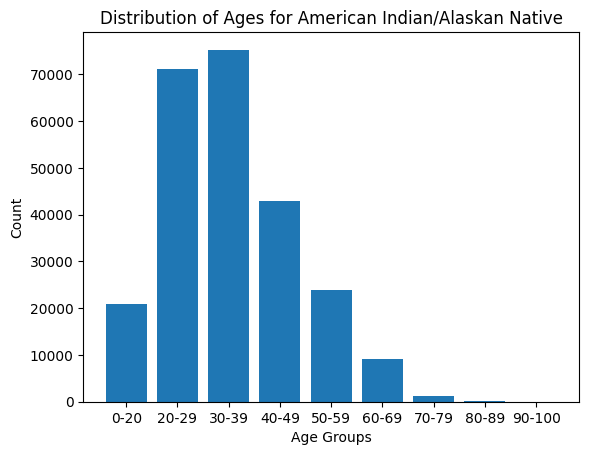

In [ ]:
for race in pretrial_df['Race'].unique():
    bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    counts, bin_edges = np.histogram(pretrial_df['Age_at_Arrest'], bins=bins)
    plt.bar(labels, counts)
    plt.title(f'Distribution of Ages for ' + race)
    plt.xlabel('Age Groups')
    plt.ylabel('Count')
    plt.show()



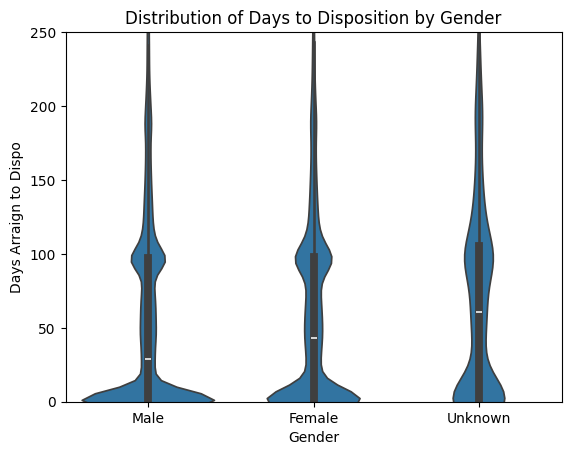

In [ ]:
sns.violinplot(data=pretrial_df, x='Gender', y='Days_Arraign_to_Dispo')
plt.ylim(0, 250)
plt.title('Distribution of Days to Disposition by Gender')
plt.xlabel('Gender')
plt.ylabel('Days Arraign to Dispo')
plt.show()


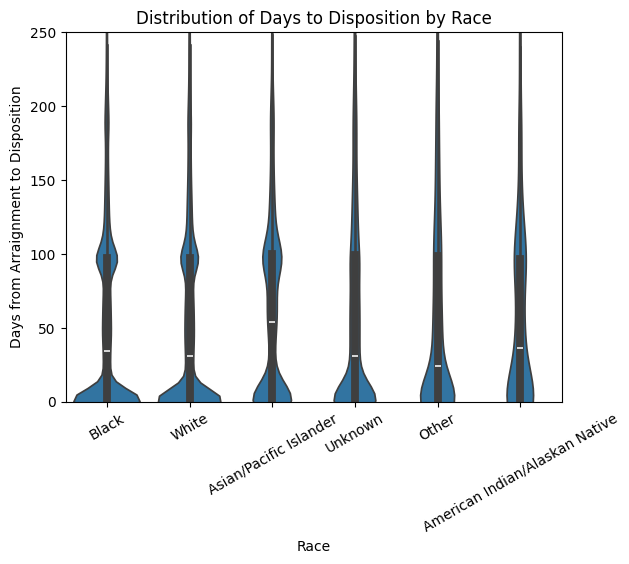

In [ ]:
sns.violinplot(data=pretrial_df, x='Race', y='Days_Arraign_to_Dispo')
plt.title('Distribution of Days to Disposition by Race')
plt.xlabel('Race')
plt.ylabel('Days from Arraignment to Disposition')
plt.xticks(rotation=30)
plt.ylim(0, 250)
plt.show()


In [ ]:
pretrial_df['Age_at_Arrest'].isnull().sum()

0

In [ ]:
for race in pretrial_df['Race']:
    pretrial_df['Bail_Set_and_Posted_at_Arraign']

#### Feature Engineering

In [ ]:
#arraignment to disposition
pretrial_df['Days_Arraign_to_Dispo'].describe()

count    244721.00000
mean         58.94486
std          70.84927
min           0.00000
25%           1.00000
50%          33.00000
75%          97.00000
max         420.00000
Name: Days_Arraign_to_Dispo, dtype: float64

In [ ]:
very_fast = pretrial_df['Days_Arraign_to_Dispo'].min()
fast = pretrial_df['Days_Arraign_to_Dispo'].quantile(0.25)
moderate = pretrial_df['Days_Arraign_to_Dispo'].median()
slow = pretrial_df['Days_Arraign_to_Dispo'].quantile(0.75)
very_slow = pretrial_df['Days_Arraign_to_Dispo'].max()
bins = [very_fast, fast, moderate, slow, very_slow]

bin_labels = ['Very Fast Resolution', 'Fast Resolution', 'Moderate Resolution', 'Slow Resolution']
pretrial_df['Resolution_Category'] = pd.cut(pretrial_df['Days_Arraign_to_Dispo'], bins=bins, labels=bin_labels, right=False)
pretrial_df['Resolution_Category'].value_counts()

Resolution_Category
Fast Resolution         69611
Slow Resolution         63646
Moderate Resolution     59173
Very Fast Resolution    52290
Name: count, dtype: int64

In [ ]:
pretrial_df['Has_Prior_Offense'] = ((pretrial_df['prior_vfo_cnt'] > 0) |
                                    (pretrial_df['prior_nonvfo_cnt'] > 0) |
                                    (pretrial_df['prior_misd_cnt'] > 0)).astype(int)
pretrial_df['Has_Prior_Offense'].value_counts()

Has_Prior_Offense
0    126123
1    118598
Name: count, dtype: int64

### Bail

Accepted Bail

In [ ]:
bail_given = pretrial_df[pretrial_df['Bail_Set_and_Posted_at_Arraign'] == 'Y']
bail_per_race = bail_given.groupby('Race').size()
bail_per_race

Race
American Indian/Alaskan Native      11
Asian/Pacific Islander             134
Black                             2242
Other                               64
Unknown                            131
White                             1339
dtype: int64

In [ ]:
bail_offered = pretrial_df[
    (pretrial_df['Bail_Set_and_Posted_at_Arraign'] == 'Y') |
    (pretrial_df['Bail_Set_and_Not_Posted_at_Arraign'] == 'Y')
]

bail_offered_per_race = bail_offered.groupby('Race').size() / pretrial_df.groupby('Race').size()
bail_offered_per_race

Race
American Indian/Alaskan Native    0.122195
Asian/Pacific Islander            0.096788
Black                             0.179369
Other                             0.142238
Unknown                           0.134681
White                             0.147007
dtype: float64

In [ ]:
bail_requested = pretrial_df[
    (pretrial_df['Bail_Set_and_Posted_at_Arraign'] == 'Y') |
    (pretrial_df['Bail_Set_and_Not_Posted_at_Arraign'] == 'Y')
]

total_bail_requests_by_race = bail_requested.groupby('Race').size()
accepted_bail_requests_by_race = bail_requested[bail_requested['Bail_Set_and_Posted_at_Arraign'] == 'Y'].groupby('Race').size()
bail_acceptance_rate = (accepted_bail_requests_by_race / total_bail_requests_by_race) * 100

bail_info_df = pd.DataFrame({
    'Total Bail Request': total_bail_requests_by_race,
    'Accepted Bail Requests': accepted_bail_requests_by_race,
    'Acceptance Rate (%)': bail_acceptance_rate}).reset_index()

bail_info_df

,Race,Total Bail Request,Accepted Bail Requests,Acceptance Rate (%)
0,American Indian/Alaskan Native,98,11,11.224490
1,Asian/Pacific Islander,922,134,14.533623
2,Black,21739,2242,10.313262
3,Other,492,64,13.008130
4,Unknown,1946,131,6.731757
5,White,14008,1339,9.558824


In [ ]:
# Calculate the reoffend rate based on demographic features (race and age group)
age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']

pretrial_df['Age_Group'] = pd.cut(pretrial_df['Age_at_Crime'], bins=age_bins, labels=age_labels)
reoffend_rate = pretrial_df.groupby(['Race', 'Age_Group'])['reoffend'].mean().reset_index()
reoffend_rate.rename(columns={'reoffend': 'Reoffend_Rate'}, inplace=True)

pretrial_df = pretrial_df.merge(reoffend_rate, on=['Race', 'Age_Group'], how='left')

print(pretrial_df[['Race', 'Age_Group', 'Reoffend_Rate']].head())

/var/folders/fy/20h6tjtj0lb6vgm0w4qt4m2c0000gn/T/ipykernel_15860/2927192393.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reoffend_rate = pretrial_df.groupby(['Race', 'Age_Group'])['reoffend'].mean().reset_index()


    Race Age_Group  Reoffend_Rate
0  Black     20-29       0.170740
1  White     50-59       0.138112
2  White     20-29       0.153303
3  White     20-29       0.153303
4  Black     20-29       0.170740


In [ ]:
pretrial_df[['Race', 'Age_Group', 'Reoffend_Rate']]

,Race,Age_Group,Reoffend_Rate
0,Black,20-29,0.170740
1,White,50-59,0.138112
2,White,20-29,0.153303
3,White,20-29,0.153303
4,Black,20-29,0.170740
...,...,...,...
244716,Black,30-39,0.179820
244717,White,20-29,0.153303
244718,Black,20-29,0.170740
244719,Other,20-29,0.119440


##### One Hot Encoding

In [ ]:
#One Hot Encode Categorical Variables
df_encoded = pd.get_dummies(pretrial_df, columns=['Gender', 'Race', 'Ethnicity', 'County_Name', 'District', 'Region', 'Court_Type', 
                                                  'Offense_Month', 'Offense_Year', 'Arrest_Month', 'Arrest_Year',
                                                  'Top_Arrest_Article_Section', 'Top_Charge_Severity_at_Arrest', 
                                                  'Top_Charge_Weight_at_Arrest', 'Top_Charge_at_Arrest_Violent_Felony_Ind',
                                                  'Case_Type', 'Top_Arraign_Law', 'Top_Severity_at_Arraign', 'Top_Charge_Weight_at_Arraign',
                                                  'Top_Charge_at_Arraign_Violent_Felony_Ind', 'Hate_Crime_Ind', 'Arraign_Charge_Category',
                                                  'Representation_Type', 'Remanded_to_Jail_at_Arraign', 'ROR_at_Arraign', 
                                                  'Bail_Set_and_Posted_at_Arraign', 'Bail_Set_and_Not_Posted_at_Arraign', 'NMR_at_Arraign',
                                                  'Release_Decision_at_Arraign', 'Pretrial_Supervision_at_Arraign', 'Contact_Pretrial_Service_Agency',
                                                  'Electronic_Monitoring', 'Travel_Restrictions', 'Passport_Surrender', 'No_Firearms_or_Weapons',
                                                  'Maintain_Employment', 'Maintain_Housing', 'Maintain_School', 'Placement_in_Mandatory_Program', 
                                                  'Removal_to_Hospital', 'Obey_Order_of_Protection', 'Obey_Court_Conditions-Family_Offense',
                                                  'Other_NMR', 'Warrant_Ordered_btw_Arraign_and_Dispo', 'DAT_WO_WS_Prior_to_Arraign', 
                                                  'Docket_Status', 'Top_Charge_at_Conviction_Violent_Felony_Ind', 'pend_vfo',
                                                  'pend_nonvfo', 'pend_misd', 'supervision', 'rearrest','Has_Prior_Offense'])
df_encoded.head()

,Internal_Case_ID,Age_at_Crime,Age_at_Arrest,Judge_Name,Top_Arrest_Law,Top_Charge_at_Arrest,First_Arraign_Date,Top_Arraign_Article_Section,Top_Charge_at_Arraign,App_Count_Arraign_to_Dispo_Released,...,pend_misd_0,pend_misd_1,supervision_0,supervision_1,rearrest_Misdemeanor,rearrest_No Arrest,rearrest_Non-violent felony,rearrest_Violent felony,Has_Prior_Offense_0,Has_Prior_Offense_1
0,0x7D5A7A079A4D37CF1E45EC4,24,24,"Hayes Torres, Patrick",PL,PL 165.40 AM Crim Possession Stoln Prop-5th,2023-09-01,165.4,PL 165.40 AM Crim Possession Stoln Prop-5th,3,...,True,False,True,False,False,True,False,False,True,False
1,0x65DA7AE4C1F68EAD828F68B,51,51,"Freire, Diego A.",PL,PL 145.00 04 AM Crim Mis 4:Prevnt Emergncy Cal,2023-04-01,145,PL 145.00 04 AM Crim Mis 4:Prevnt Emergncy Cal,3,...,True,False,True,False,False,True,False,False,True,False
2,0x74775A9DB79BE9D2562A37B,30,30,"Mcallister, Ryan",PL,PL 120.03 01 EF Vehicular Assault 2nd: Injury,2023-09-01,120.03,PL 120.03 01 EF Vehicular Assault 2nd: Injury,4,...,True,False,True,False,False,True,False,False,True,False
3,0x44403907DC0611F6DD9BE0F,29,29,"Weiner, Jay L.",PL,PL 120.14 01 AM Menacing-2nd:Weapon,2023-02-01,120.14,PL 120.14 01 AM Menacing-2nd:Weapon,2,...,True,False,True,False,False,True,False,False,False,True
4,0xE67EB1E8C111209F555FC8E,30,30,"Haniff, Simiyon S.",PL,PL 165.15 03 AM Intent/Fraud Obt Trans W/O Pay,2023-12-01,165.15,PL 165.15 03 AM Intent/Fraud Obt Trans W/O Pay,1,...,True,False,True,False,False,True,False,False,False,True


In [ ]:
# Special Columns

#How do we want to handle these values?
# df_encoded['Court_Name'].unique()
# df_encoded['Court_ORI'].unique()
# df_encoded['County_Name'].unique()

# df_encoded['Judge_Name'].unique()

# df_encoded['Top_Arrest_Law'].unique()
# df_encoded['Top_Arrest_Article_Section'].unique() #Needs further looking
# df_encoded['Top_Charge_at_Arrest'].unique()
# df_encoded['Top_Arraign_Article_Section'].unique()
# df_encoded['Top_Charge_at_Arraign'].unique() #9
# df_encoded['arr_cycle_id'].unique()

In [ ]:
df_encoded.head()

,Internal_Case_ID,Age_at_Crime,Age_at_Arrest,Judge_Name,Top_Arrest_Law,Top_Charge_at_Arrest,First_Arraign_Date,Top_Arraign_Article_Section,Top_Charge_at_Arraign,App_Count_Arraign_to_Dispo_Released,...,pend_misd_0,pend_misd_1,supervision_0,supervision_1,rearrest_Misdemeanor,rearrest_No Arrest,rearrest_Non-violent felony,rearrest_Violent felony,Has_Prior_Offense_0,Has_Prior_Offense_1
0,0x7D5A7A079A4D37CF1E45EC4,24,24,"Hayes Torres, Patrick",PL,PL 165.40 AM Crim Possession Stoln Prop-5th,2023-09-01,165.4,PL 165.40 AM Crim Possession Stoln Prop-5th,3,...,True,False,True,False,False,True,False,False,True,False
1,0x65DA7AE4C1F68EAD828F68B,51,51,"Freire, Diego A.",PL,PL 145.00 04 AM Crim Mis 4:Prevnt Emergncy Cal,2023-04-01,145,PL 145.00 04 AM Crim Mis 4:Prevnt Emergncy Cal,3,...,True,False,True,False,False,True,False,False,True,False
2,0x74775A9DB79BE9D2562A37B,30,30,"Mcallister, Ryan",PL,PL 120.03 01 EF Vehicular Assault 2nd: Injury,2023-09-01,120.03,PL 120.03 01 EF Vehicular Assault 2nd: Injury,4,...,True,False,True,False,False,True,False,False,True,False
3,0x44403907DC0611F6DD9BE0F,29,29,"Weiner, Jay L.",PL,PL 120.14 01 AM Menacing-2nd:Weapon,2023-02-01,120.14,PL 120.14 01 AM Menacing-2nd:Weapon,2,...,True,False,True,False,False,True,False,False,False,True
4,0xE67EB1E8C111209F555FC8E,30,30,"Haniff, Simiyon S.",PL,PL 165.15 03 AM Intent/Fraud Obt Trans W/O Pay,2023-12-01,165.15,PL 165.15 03 AM Intent/Fraud Obt Trans W/O Pay,1,...,True,False,True,False,False,True,False,False,False,True


### **Model Development without Debiasing**

In [ ]:
pretrial_df['Age_at_Arrest']

0         24
1         51
2         30
3         29
4         30
          ..
244716    31
244717    30
244718    27
244719    27
244720    34
Name: Age_at_Arrest, Length: 244721, dtype: int64

In [ ]:
pretrial_df['Top_Arraign_Law'].value_counts()

Top_Arraign_Law
PL     221599
VTL     20022
COR       738
AM        278
AC        188
TAX       156
ED        103
ABC        56
PHL        38
PRR         6
LAB         5
LOC         5
ECL         5
WC          3
CAN         3
MTA         3
GB          2
RPA         2
AGM         1
SW          1
RSS         1
SCL         1
CPL         1
TOH         1
HC          1
TIS         1
Name: count, dtype: int64

## Arraign Law Codes

- **PL** – Penal Law  
- **VTL** – Vehicle and Traffic Law  
- **COR** – Corrections Law  
- **AM** – Administrative Law  
- **AC** – Arbitration Court / Administrative Code  
- **TAX** – Tax Law  
- **ED** – Education Law  
- **ED** – Education Law  
- **ABC** – Alcoholic Beverage Control Law  
- **PHL** – Public Health Law  
- **PRR** – Public Records Law / Property Rights Regulation  
- **LAB** – Labor Law  
- **LOC** – Local Law / Local Ordinances Code  
- **ECL** – Environmental Conservation Law  
- **WC** – Workers’ Compensation Law  
- **CAN** – Canon Law (or possibly Canadian law if referring to international legal systems)  
- **MTA** – Metropolitan Transportation Authority Law  
- **GB** – General Business Law  
- **RPA** – Real Property Actions and Proceedings Law  
- **AGM** – Attorney General’s Manual (or Agency Management Law)  
- **SW** – Social Welfare Law  
- **RSS** – Revised Statutes Supplement  
- **SCL** – State Civil Law / State Construction Law  
- **CPL** – Criminal Procedure Law  
- **TOH** – Town or Housing Law  
- **HC** – Housing Code / Habeas Corpus Law  
- **TIS** – Transportation and Infrastructure Law  


In [ ]:
def map_severity(abbreviation):
    severity_mapping = {
        5: {"PL", "CPL", "LAB", "COR", "HC"},
        4: {"VTL", "TAX", "ECL", "PHL", "WC"},
        3: {"GB", "RPA", "LOC", "AGM", "MTA"},
        2: {"AC", "AM", "SCL", "TOH", "SW", "PRR"},
        1: {"ABC", "RSS", "CAN", "TIS", "ED"}
    }
    
    for severity, codes in severity_mapping.items():
        if abbreviation in codes:
            return severity
    return 0 

pretrial_df["crime_severity"] = pretrial_df["Top_Arraign_Law"].apply(map_severity)

In [ ]:
pretrial_df = pretrial_df[pretrial_df['crime_severity'] != 0]
pretrial_df['crime_severity'].value_counts()

crime_severity
5    222344
4     20224
2       475
1       164
3        13
Name: count, dtype: int64

In [ ]:
df_arraign_encoded = pd.get_dummies(pretrial_df, columns = ['Top_Arraign_Law'])

In [ ]:
df_arraign_encoded = df_arraign_encoded.iloc[:,-26:]

In [ ]:
pretrial_df['pend_vfo']

0         0
1         0
2         0
3         0
4         0
         ..
244716    0
244717    0
244718    0
244719    0
244720    0
Name: pend_vfo, Length: 243220, dtype: int64

In [ ]:
pretrial_df['pend_nonvfo']

0         0
1         0
2         0
3         0
4         0
         ..
244716    1
244717    0
244718    0
244719    0
244720    0
Name: pend_nonvfo, Length: 243220, dtype: int64

In [ ]:
pretrial_df['pend_misd']

0         0
1         0
2         0
3         0
4         0
         ..
244716    1
244717    0
244718    0
244719    0
244720    0
Name: pend_misd, Length: 243220, dtype: int64

In [ ]:
pretrial_df['prior_misd_cnt']
pretrial_df['prior_misd_binary'] =  pretrial_df['prior_misd_cnt'].apply(lambda x: 0 if x == 0 else 1)

In [ ]:
pretrial_df['prior_nonvfo_cnt']
pretrial_df['prior_nonvfo_binary'] =  pretrial_df['prior_nonvfo_cnt'].apply(lambda x: 0 if x == 0 else 1)

In [ ]:
pretrial_df['prior_vfo_cnt']
pretrial_df['prior_vfo_binary'] =  pretrial_df['prior_vfo_cnt'].apply(lambda x: 0 if x == 0 else 1)

In [ ]:
target_column = pretrial_df['reoffend']
random_forest_df = pretrial_df[['prior_misd_binary', 'prior_vfo_binary', 'prior_nonvfo_binary', 'pend_vfo', 'pend_nonvfo', 'pend_misd', 'Age_at_Arrest', 'crime_severity']]
factors = pd.concat([random_forest_df, df_arraign_encoded], axis = 1)

In [ ]:
factors

,prior_misd_binary,prior_vfo_binary,prior_nonvfo_binary,pend_vfo,pend_nonvfo,pend_misd,Age_at_Arrest,crime_severity,Top_Arraign_Law_ABC,Top_Arraign_Law_AC,...,Top_Arraign_Law_PRR,Top_Arraign_Law_RPA,Top_Arraign_Law_RSS,Top_Arraign_Law_SCL,Top_Arraign_Law_SW,Top_Arraign_Law_TAX,Top_Arraign_Law_TIS,Top_Arraign_Law_TOH,Top_Arraign_Law_VTL,Top_Arraign_Law_WC
0,0,0,0,0,0,0,24,5,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,0,0,0,0,0,51,5,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,0,0,0,0,0,30,5,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,0,0,0,0,0,29,5,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,0,0,0,0,0,30,5,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244716,0,0,0,0,1,1,31,5,False,False,...,False,False,False,False,False,False,False,False,False,False
244717,0,0,0,0,0,0,30,5,False,False,...,False,False,False,False,False,False,False,False,False,False
244718,1,0,0,0,0,0,27,5,False,False,...,False,False,False,False,False,False,False,False,False,False
244719,0,0,0,0,0,0,27,5,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
X = factors
y = target_column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = random_forest.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8351081325548886

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     40773
           1       0.34      0.02      0.04      7871

    accuracy                           0.84     48644
   macro avg       0.59      0.51      0.47     48644
weighted avg       0.76      0.84      0.77     48644



In [ ]:
feature_importances = random_forest.feature_importances_
feature_importance_pair = list(zip(X.columns, feature_importances))
sorted_importances = sorted(feature_importance_pair, key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importances[:10]:
    print(f"{feature}: {importance:.2f}")


Age_at_Arrest: 0.41
pend_misd: 0.24
pend_nonvfo: 0.13
prior_misd_binary: 0.09
prior_nonvfo_binary: 0.03
pend_vfo: 0.02
Top_Arraign_Law_PL: 0.02
prior_vfo_binary: 0.02
crime_severity: 0.02
Top_Arraign_Law_VTL: 0.01


In [ ]:
pretrial_test_df = pretrial_df.loc[X_test.index].copy()
pretrial_test_df["prediction"] = y_pred

### **Bias Mitigation**

In [ ]:
overall_analysis = pretrial_test_df.groupby(["Race", "Ethnicity"])["prediction"].mean().reset_index()
print(overall_analysis)

                              Race     Ethnicity  prediction
0   American Indian/Alaskan Native      Hispanic    0.000000
1   American Indian/Alaskan Native  Non Hispanic    0.006536
2   American Indian/Alaskan Native       Unknown    0.000000
3           Asian/Pacific Islander      Hispanic    0.000000
4           Asian/Pacific Islander  Non Hispanic    0.006316
5           Asian/Pacific Islander       Unknown    0.000000
6                            Black      Hispanic    0.009934
7                            Black  Non Hispanic    0.011868
8                            Black       Unknown    0.018293
9                            Other      Hispanic    0.009747
10                           Other  Non Hispanic    0.016393
11                           Other       Unknown    0.000000
12                         Unknown      Hispanic    0.000000
13                         Unknown  Non Hispanic    0.000000
14                         Unknown       Unknown    0.005281
15                      

In [ ]:
race_analysis = pretrial_test_df.groupby("Race")["prediction"].mean().reset_index()
ethnicity_analysis = pretrial_test_df.groupby("Ethnicity")["prediction"].mean().reset_index()


/var/folders/fy/20h6tjtj0lb6vgm0w4qt4m2c0000gn/T/ipykernel_15860/2507161755.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=race_analysis, x="Race", y="prediction", palette="viridis")


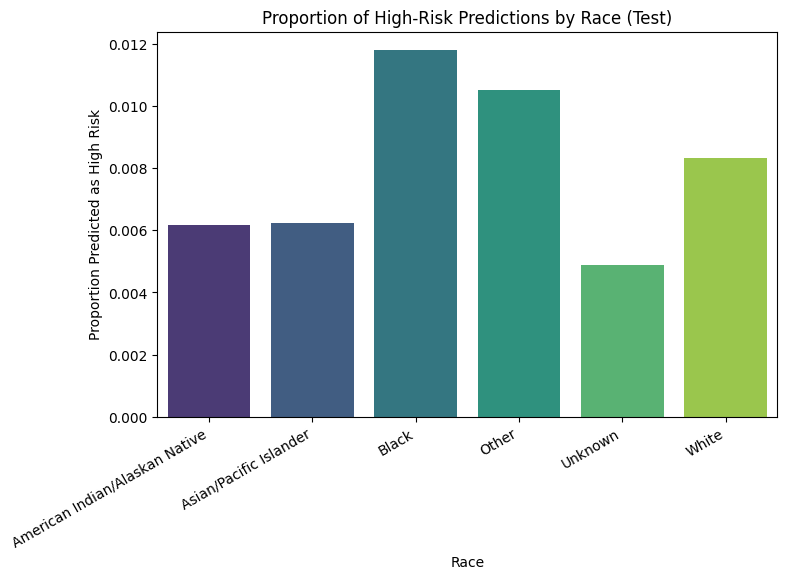

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=race_analysis, x="Race", y="prediction", palette="viridis")

plt.xlabel("Race")
plt.ylabel("Proportion Predicted as High Risk")
plt.title("Proportion of High-Risk Predictions by Race (Test)")
plt.xticks(rotation=30, ha='right')
plt.show()

/var/folders/fy/20h6tjtj0lb6vgm0w4qt4m2c0000gn/T/ipykernel_15860/1219612518.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ethnicity_analysis, x="Ethnicity", y="prediction", palette="viridis")


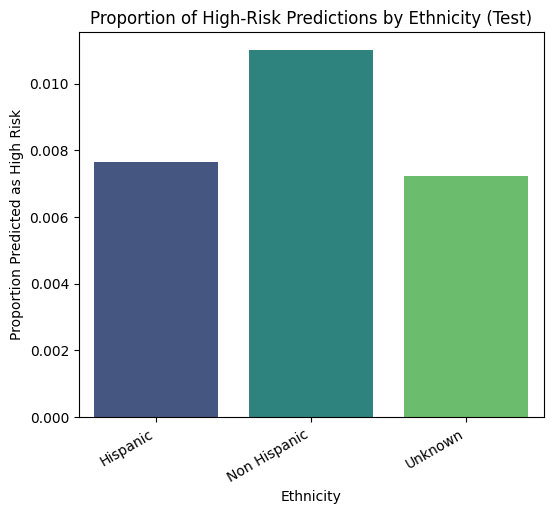

In [ ]:
plt.figure(figsize=(6, 5))
sns.barplot(data=ethnicity_analysis, x="Ethnicity", y="prediction", palette="viridis")

plt.xlabel("Ethnicity")
plt.ylabel("Proportion Predicted as High Risk")
plt.title("Proportion of High-Risk Predictions by Ethnicity (Test)")
plt.xticks(rotation=30, ha='right')
plt.show()


In [ ]:
anova_result = stats.f_oneway(*[group["prediction"].values for _, group in pretrial_test_df.groupby("Race")])
print("ANOVA p-value:", anova_result.pvalue)


ANOVA p-value: 0.00020236918689354536


In [ ]:
group1 = pretrial_test_df[pretrial_test_df["Race"] == "White"]["prediction"]
group2 = pretrial_test_df[pretrial_test_df["Race"] == "Black"]["prediction"]
t_test_result = stats.ttest_ind(group1, group2, equal_var=False)
print("T-test p-value:", t_test_result.pvalue)


T-test p-value: 0.00028158521145064686


In [ ]:
metrics = {}

for race in pretrial_test_df["Race"].unique():
    group = pretrial_test_df[pretrial_test_df["Race"] == race]
    y_true = group["reoffend"]
    y_pred = group["prediction"] 
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0 
    metrics[race] = fpr

fpr = pd.DataFrame(list(metrics.items()), columns=["Race", "FPR"])

print(fpr)


                             Race       FPR
0                           Black  0.009265
1                           White  0.006701
2          Asian/Pacific Islander  0.005254
3                         Unknown  0.002867
4                           Other  0.006757
5  American Indian/Alaskan Native  0.007519


/var/folders/fy/20h6tjtj0lb6vgm0w4qt4m2c0000gn/T/ipykernel_15860/3009669082.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fpr, x="Race", y="FPR", palette="viridis")


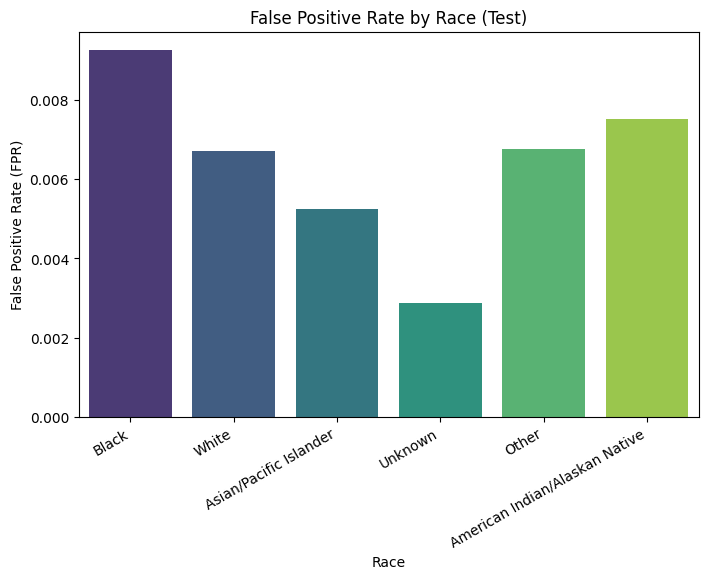

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=fpr, x="Race", y="FPR", palette="viridis")

plt.xlabel("Race")
plt.ylabel("False Positive Rate (FPR)")
plt.title("False Positive Rate by Race (Test)")
plt.xticks(rotation=30, ha='right')
plt.show()


### **Bias Mitigation with AIF360**

In [ ]:
# Dataframe with Factors, Target Variable, and Race
target_column = pretrial_df['reoffend']
aif_factors = pd.concat([factors, pretrial_df['Race']], axis = 1)
aif_factors.head()

aif_df = pd.concat([aif_factors, target_column], axis = 1)
print(aif_df.columns)
print(aif_df.dtypes)

Index(['prior_misd_binary', 'prior_vfo_binary', 'prior_nonvfo_binary',
       'pend_vfo', 'pend_nonvfo', 'pend_misd', 'Age_at_Arrest',
       'crime_severity', 'Top_Arraign_Law_ABC', 'Top_Arraign_Law_AC',
       'Top_Arraign_Law_AGM', 'Top_Arraign_Law_AM', 'Top_Arraign_Law_CAN',
       'Top_Arraign_Law_COR', 'Top_Arraign_Law_CPL', 'Top_Arraign_Law_ECL',
       'Top_Arraign_Law_ED', 'Top_Arraign_Law_GB', 'Top_Arraign_Law_HC',
       'Top_Arraign_Law_LAB', 'Top_Arraign_Law_LOC', 'Top_Arraign_Law_MTA',
       'Top_Arraign_Law_PHL', 'Top_Arraign_Law_PL', 'Top_Arraign_Law_PRR',
       'Top_Arraign_Law_RPA', 'Top_Arraign_Law_RSS', 'Top_Arraign_Law_SCL',
       'Top_Arraign_Law_SW', 'Top_Arraign_Law_TAX', 'Top_Arraign_Law_TIS',
       'Top_Arraign_Law_TOH', 'Top_Arraign_Law_VTL', 'Top_Arraign_Law_WC',
       'Race', 'reoffend'],
      dtype='object')
prior_misd_binary       int64
prior_vfo_binary        int64
prior_nonvfo_binary     int64
pend_vfo                int64
pend_nonvfo             

In [ ]:
aif_df

,prior_misd_binary,prior_vfo_binary,prior_nonvfo_binary,pend_vfo,pend_nonvfo,pend_misd,Age_at_Arrest,crime_severity,Top_Arraign_Law_ABC,Top_Arraign_Law_AC,...,Top_Arraign_Law_SW,Top_Arraign_Law_TAX,Top_Arraign_Law_TIS,Top_Arraign_Law_TOH,Top_Arraign_Law_VTL,Top_Arraign_Law_WC,Gender,Race,Ethnicity,reoffend
0,0,0,0,0,0,0,24,5,False,False,...,False,False,False,False,False,False,1.0,0.0,1.0,0
1,0,0,0,0,0,0,51,5,False,False,...,False,False,False,False,False,False,1.0,1.0,0.0,0
2,0,0,0,0,0,0,30,5,False,False,...,False,False,False,False,False,False,1.0,1.0,1.0,0
3,1,0,0,0,0,0,29,5,False,False,...,False,False,False,False,False,False,1.0,1.0,0.0,0
4,1,0,0,0,0,0,30,5,False,False,...,False,False,False,False,False,False,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244716,0,0,0,0,1,1,31,5,False,False,...,False,False,False,False,False,False,1.0,0.0,1.0,0
244717,0,0,0,0,0,0,30,5,False,False,...,False,False,False,False,False,False,1.0,1.0,1.0,0
244718,1,0,0,0,0,0,27,5,False,False,...,False,False,False,False,False,False,1.0,0.0,1.0,0
244719,0,0,0,0,0,0,27,5,False,False,...,False,False,False,False,False,False,1.0,NaN,NaN,1


In [ ]:
pretrial_df['Race'].unique()

array(['Black', 'White', 'Asian/Pacific Islander', 'Unknown', 'Other',
       'American Indian/Alaskan Native'], dtype=object)

In [ ]:
class PretrialDataset(StandardDataset):
    def __init__(self, pretrial_df, 
                 label_name='reoffend', 
                 protected_attribute_names=['Race'], 
                 privileged_classes=['White', 'Asian/Pacific Islander', 'Unknown', 'Other',
       'American Indian/Alaskan Native'], 
                 categorical_features=[], 
                 features_to_keep=[],  
                 features_to_drop=[]): 

        # Convert protected attribute Race to binary (1 = privileged, 0 = unprivileged)
        pretrial_df['Race'] = pretrial_df['Race'].apply(lambda x: 1 if x in privileged_classes else 0)
        
        super().__init__(df=pretrial_df, 
                         label_name=label_name, 
                         favorable_classes=[1], 
                         protected_attribute_names=protected_attribute_names, 
                         privileged_classes=[[1]], 
                         instance_weights_name=None, 
                         scores_name='', 
                         categorical_features=categorical_features, 
                         features_to_keep=features_to_keep, 
                         features_to_drop=features_to_drop, 
                         na_values=[], 
                         custom_preprocessing=None, 
                         metadata={})


pretrial = PretrialDataset(aif_df)


In [ ]:
binary_label_dataset = BinaryLabelDataset(
    df=aif_df,  # The DataFrame from pretrial
    label_names=['reoffend'],  # Column name for the label
    protected_attribute_names=['Race'],  # Protected attribute
    favorable_label= 0,  # The favorable label (reoffend = 0)
    unfavorable_label= 1  # The unfavorable label (reoffend = 1)
)

In [ ]:
dataset_metric = BinaryLabelDatasetMetric(
    binary_label_dataset,
    unprivileged_groups=[{'Race': 0}], 
    privileged_groups=[{'Race': 1}]      # Privileged group (White, Asian, etc.)
)

In [ ]:
# Create an explainer
explainer_orig_panel19_train = MetricTextExplainer(dataset_metric)

# Print the disparate impact
print(explainer_orig_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9784976928450018


### **Model Iteration**

In [ ]:
# Dataframe with Factors, Target Variable, and Race
target_column = pretrial_df['reoffend']
aif_factors = pd.concat([factors, pretrial_df[['Gender', 'Race', 'Ethnicity']]], axis=1)

aif_factors.head()

aif_df = pd.concat([aif_factors, target_column], axis = 1)
aif_df = aif_df.dropna(subset=['Gender', 'Race', 'Ethnicity', 'reoffend'])

aif_df['Gender'] = aif_df['Gender'].map({'Male': 1, 'Female': 0})
aif_df['Race'] = aif_df['Race'].map({
    'Black': 0,
    'Asian/Pacific Islander': 0,
    'American Indian/Alaskan Native': 0,
    'White': 1  # Privileged group
})
aif_df['Ethnicity'] = aif_df['Ethnicity'].map({'Hispanic': 0, 'Non Hispanic': 1})

In [ ]:
from aif360.datasets import StandardDataset

# Select relevant columns
protected_attributes = ["Gender", "Race", "Ethnicity"]
target_variable = "reoffend"

# Create an AIF360-compatible dataset
aif_dataset = StandardDataset(
    aif_df,
    label_name=target_variable,
    favorable_classes=[0],
    protected_attribute_names=protected_attributes,
    privileged_classes=[[1], [1], [1]]  # Define privileged groups
)

In [110]:
metric = BinaryLabelDatasetMetric(aif_dataset, unprivileged_groups=[{'Ethnicity': 0, 'Gender': 0, 'Race': 0}], privileged_groups=[{'Ethnicity': 1, 'Gender': 1, 'Race': 0}])
explainer = MetricTextExplainer(metric)

print(explainer.disparate_impact())
print("Disparate Impact Ratio:", metric.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0625738158539189
Disparate Impact Ratio: 1.0625738158539189


In [142]:
from sklearn.pipeline import make_pipeline

# get the dataset and split into train (50%), val (30%), and test (20%)
train, val, testing = aif_dataset.split([0.5, 0.8], shuffle=True)

model = make_pipeline(
    RandomForestClassifier(n_estimators=100, random_state=42)
)
fit_params = {'randomforestclassifier__sample_weight': train.instance_weights}
rf_train = model.fit(train.features, train.labels.ravel(), **fit_params)


In [119]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=[{'Race': 0}],
                privileged_groups=[{'Race': 1}])

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [ ]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=train,
                   model=rf_train,
                   thresh_arr=thresh_arr)

rf_orig_best_ind = np.argmax(val_metrics['bal_acc'])

In [136]:
import matplotlib.pyplot as plt
import numpy as np

def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    
    ax1.plot(x, y_left, color='blue', label=y_left_name)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='blue', fontsize=16, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='red', label=y_right_name)
    ax2.set_ylabel(y_right_name, color='red', fontsize=16, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='red')

    best_ind = np.argmax(y_left)
    ax1.axvline(x[best_ind], color='k', linestyle=':')

    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()



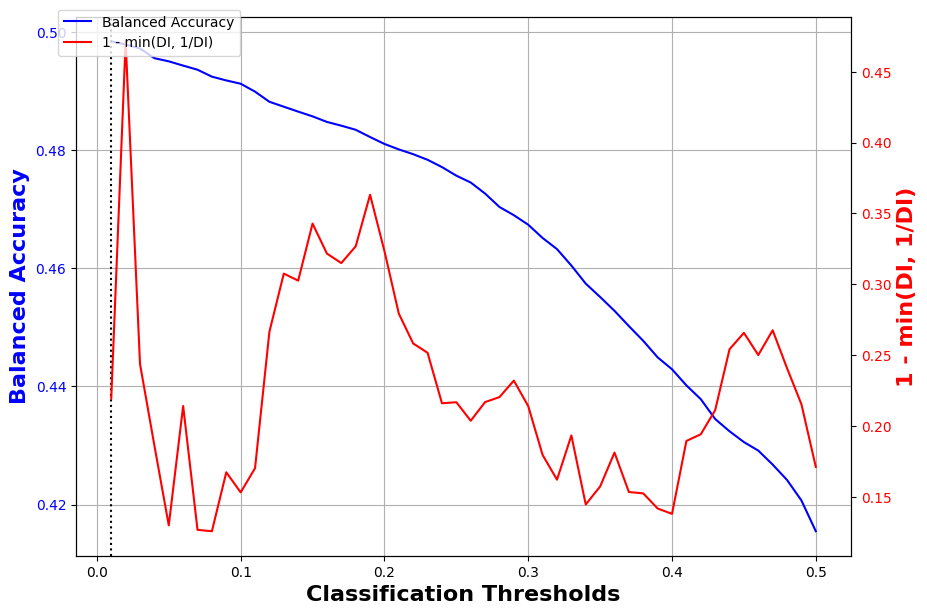

In [137]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

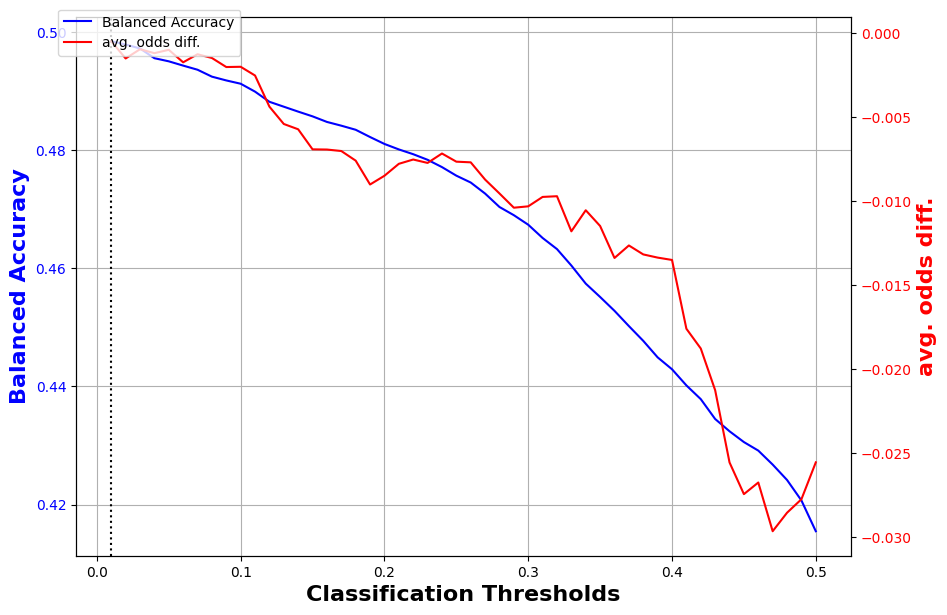

In [138]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [139]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [140]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.4984
Corresponding 1-min(DI, 1/DI) value: 0.2195
Corresponding average odds difference value: -0.0005
Corresponding statistical parity difference value: -0.0001
Corresponding equal opportunity difference value: 0.0000
Corresponding Theil index value: 1.8037


##### Testing RF model

In [143]:
rf_orig_metrics = test(dataset=testing,
                       model=rf_train,
                       thresh_arr=[thresh_arr[rf_orig_best_ind]])

In [144]:
describe_metrics(rf_orig_metrics, [thresh_arr[rf_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.4994
Corresponding 1-min(DI, 1/DI) value: 0.5538
Corresponding average odds difference value: -0.0009
Corresponding statistical parity difference value: -0.0004
Corresponding equal opportunity difference value: -0.0002
Corresponding Theil index value: 1.8200
